<순서>

라이브러리 import -> 데이터 전처리 -> 모델 학습 -> 예측(테스트)

# 라이브러리

In [3]:
import pandas as pd
import numpy as np

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

### 라이브러리 개념 확인하기

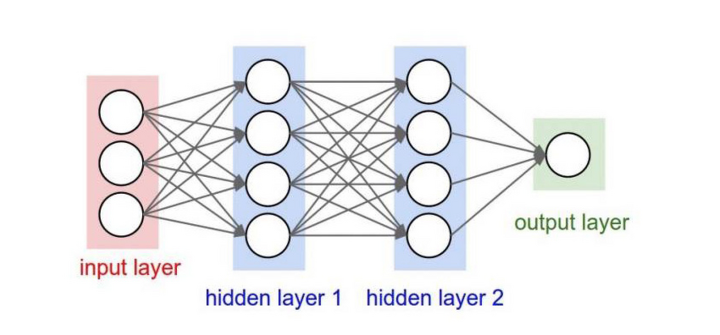

* tensorflow 

데이터프레임을 array형식으로 바꿔 행렬 연산하는 딥러닝 라이브러리 (행렬연산 = 인공신경망)

* Sequential

계층을 층층이 선형으로 쌓는 모델; (선형은 $Y = w1x1 + w2x2$ 처럼 행렬로 연산될 수 있는 것)

* Dense

fully-connected layers 완전히 연결된 레이어

* RNN(Recurrent Neural Network)

이전의 정보를 복사해서 과거 정보 바탕 예측(과거의 이벤트가 미래의 결과에 영향을 줄 수 있는 순환구조를 가짐) 

"the clouds are in the ___"

* LSTM(Long Short-Term Memory)

RNN의'장기 의존성 문제'를 보완한 것. 장기 의존성 문제란 먼 과거의 이벤트를 고려하지 못하는, 전체 맥락을 파악하지 못하는 문제.

"I grew up in France... I speak fluent ___ "


* GRU(Gated Recurrent Unit)

LSTM의 간소화된 버전.

LSTM 설명 참고 https://teddylee777.github.io/tensorflow/lstm-layer


In [2]:
# pip install --upgrade keras==2.4.3

Note: you may need to restart the kernel to use updated packages.


# 데이터 전처리

In [4]:
train_label = pd.read_csv('./data/train_labels.csv')
train_feature = pd.read_csv('./data/train_features.csv')
test_feature = pd.read_csv('./data/test_features.csv') 
sample_submission = pd.read_csv('./data/sample_submission.csv')

데이터를 불러옵니다. 훈련 데이터, test 데이터, 답안지입니다.

훈련 데이터로 학습한 모델을 이용해, test 데이터로 결과를 예측하고, 답안지에 적어 제출하는 것이 대회 형식입니다.

In [6]:
train_feature.head(601)

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
596,0,596,1.052837,-0.220710,-0.413472,-10.857025,19.786856,23.174597
597,0,597,1.025643,-0.227845,-0.354516,-2.334243,25.768654,18.932070
598,0,598,1.031553,-0.387862,-0.277857,-9.710746,28.697694,20.631577
599,0,599,1.138159,-0.426846,-0.430263,-15.891015,21.675950,32.123007


### 데이터 특징

- 6개 feature, 61개 label

- 총 1875000개 데이터 (한 id * 600개 데이터)

- 여기서 600은 12초를 0.02초 간격으로 나눈 개수

In [10]:
X = tf.reshape(np.array(train_feature.iloc[:,2:]), [-1, 600, 6])

print('원본 데이터 프레임', train_feature.shape, '--> np.array', X.shape)
X

원본 데이터 프레임 (1875000, 8) --> np.array (3125, 600, 6)


<tf.Tensor: shape=(3125, 600, 6), dtype=float64, numpy=
array([[[ 1.20608659e+00, -1.79371436e-01, -1.48446664e-01,
         -5.91607848e-01, -3.05490095e+01, -3.16761119e+01],
        [ 1.28769648e+00, -1.98973718e-01, -1.82443746e-01,
          3.03100213e-01, -3.91391031e+01, -2.49272160e+01],
        [ 1.30460912e+00, -1.95114490e-01, -2.53382483e-01,
         -3.61727754e+00, -4.41225645e+01, -2.50196286e+01],
        ...,
        [ 1.02564277e+00, -2.27845498e-01, -3.54516277e-01,
         -2.33424265e+00,  2.57686541e+01,  1.89320704e+01],
        [ 1.03155302e+00, -3.87862493e-01, -2.77856696e-01,
         -9.71074629e+00,  2.86976939e+01,  2.06315770e+01],
        [ 1.13815923e+00, -4.26846194e-01, -4.30263172e-01,
         -1.58910155e+01,  2.16759504e+01,  3.21230070e+01]],

       [[-2.11794694e-01, -7.87595918e-02,  8.54626552e-01,
          1.82319428e+01,  1.02111637e+01,  7.39034752e+00],
        [-2.56963191e-01, -1.85552045e-02,  8.02171682e-01,
          2.65242628e+

### 데이터프레임을 array형식으로 바꾸기

1. np.array(train_feature.iloc[:,2:])

- id, time을 제외한 나머지 데이터를 (1875000, 6)의 np.array로 만들기

2. tf.reshape ... ([-1, 600, 6])

- (3125, 600, 6)의 3차원으로 재배열
- (-1)개씩 묶어 첫번째 차원, 600개씩 묶어 두번째 차원, 그 안에 6개 든 세번째 차원

In [93]:
# 원본 데이터프레임과 비교
train_feature

### TensorShape([3125, 600, 6]) 

(batch,  time_step,  feature)

* batch

한번에 학습하는 묶음. 여기서는 한 개 id가 600개 데이터를 가지고 있으므로, 600개씩 묶어 3,125개 배치를 형성함.

* time step

12초를 0.02초 간격으로 나눠 600개의 time step를 형성했음. 시간 뿐만 아니라 공간, 너비, 높이의 차원이 될 수 있음.

* feature

6개의 


In [17]:
y = tf.keras.utils.to_categorical(train_label['label']) 
print(y.shape)
y

(3125, 61)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

### 멀티클래스 엔코딩

train_label 데이터 프레임에서 'label' 칼럼을 one-hot encoding하여 (3125, 61)으로 재배열합니다. 운동(라벨)의 종류가 61개입니다.

멀티클래스나 다중분류 레이블이나 같은 말입니다.

# 모델 셋팅

Dense 레이어는 무엇인지? 히든 레이어의 개수는 어떤 기준으로 정하는지? 아래 모델에서 히든 레이어의 개수는 몇 개인지?

노드의 개수는?

In [21]:
model = Sequential()

# TensorShape([3125, 600, 6])
# input_shape: 배치 차원은(batch dimension) 포함하지 않습니다 
model.add(LSTM(32, input_shape=(600,6)))

model.add(Dense(128, activation='relu')) 

# 출력개수를 61개로 셋팅하고, 다중분류이므로 softmax함수를 씁니다. 이진분류의 경우 sigmoid 함수를 씁니다.
model.add(Dense(61, activation='softmax')) 

model.compile(  # 최적화 함수
              optimizer='rmsprop', 
              
                # 손실함수
              loss='categorical_crossentropy',
              
                # 평가지표: 평가지표로 정확도를 보겠습니다.
              metrics=['accuracy']) 

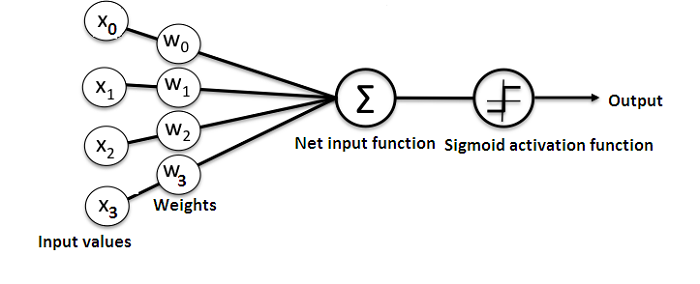

### 활성화 함수

인간의 뉴런 세포는 자극을 받으면(입력) 전기신호를 발생시켜(출력) 다른 세포에 정보를 전달합니다(입력) (ex) 통증의 전기신호.

활성화함수는 입력값을 넣으면 출력 신호로 변환해주는 함수입니다. 이때 입력값이 임계값을 넘어야 활성화됩니다.

예를 들어, relu는 0 이상 일 때 x로 출력하고 그 이하일 때 0으로 출력합니다.

Sigmoid는 0과 1 사이의 값으로 출력해주는데, 경사도가 0에 가까워져 사라져버리는 위험(Vanishing Gradient)이 있습니다.

따라서 요즘은 relu를 더 많이 사용합니다.

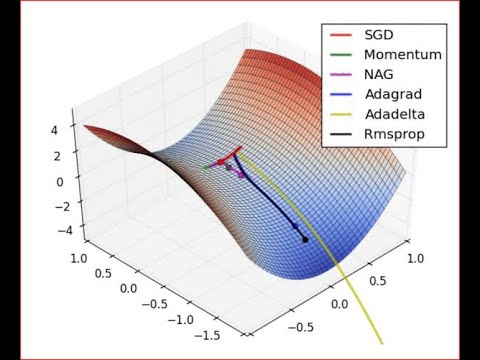

### 최적화 함수

RMSProp: 과거의 모든 기울기를 균일하게 더하지 않고 새로운 기울기의 정보만 반영하도록 해서, 학습률이 크게 떨어져 0에 가까워지는 것을 방지하는 방법이다 (https://sacko.tistory.com/42 )

cf) Adam은 RMSProp에 Momentum을 섞은 기법: 우리 모델에 Adam을 사용했을 때 정확도가 미세하게 올라갔습니다.

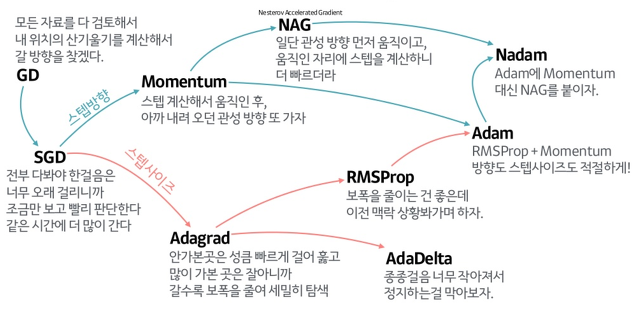

### 손실함수

mse, categorical_crossentropy 등등이 있습니다.

그 중 categorical_crossentropy는 다중분류에 사용되는 손실함수입니다.

손실 함수를 최소화하는 방향으로 학습해야 합니다. 그것이 우리의 목표입니다.

categorical_crossentropy는 라벨이 원핫엔코딩 형태로 제공됩니다.

위 두식의 Loss는 각각 MSE , CEE 가 되는데 이에 따라 연속적 분포를 갖는 데이터(Regression) 에는 MSE가 적합하고 이산적 분포를 갖는 데이터(Classification) 에는 CEE가 적합하다고 생각할 수 있다.  https://simpling.tistory.com/15

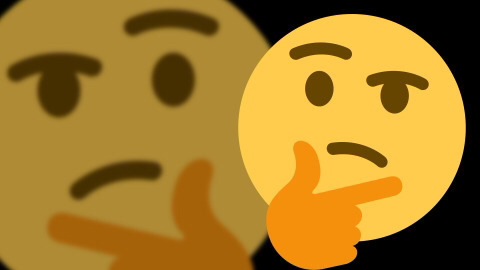


1. 손실함수를 최소화하는 방법으로서 경사하강법을 씁니다.

2. 경사하강법은 기울기, 즉 미분값을 구해 내려가는 방법입니다.

3. 미분값(역전파)을 확인해 업데이트하는 알고리즘인 것입니다.

# 학습

배치 사이즈는 어떻게 정하지?

배치 사이즈를 줄이면 일반화에 편하다 (한번에 계산하는 데이터양이 많아지므로) ?

In [22]:
model.fit(X, y, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
50/50 [==============================] - 7s 145ms/step - loss: 3.2184 - accuracy: 0.4536 - val_loss: 2.7319 - val_accuracy: 0.4976
Epoch 2/30
50/50 [==============================] - 6s 127ms/step - loss: 2.7177 - accuracy: 0.4828 - val_loss: 2.6524 - val_accuracy: 0.4976
Epoch 3/30
50/50 [==============================] - 6s 124ms/step - loss: 2.6285 - accuracy: 0.4828 - val_loss: 2.6079 - val_accuracy: 0.4976
Epoch 4/30
50/50 [==============================] - 6s 123ms/step - loss: 2.5498 - accuracy: 0.4828 - val_loss: 2.5581 - val_accuracy: 0.4944
Epoch 5/30
50/50 [==============================] - 6s 122ms/step - loss: 2.4772 - accuracy: 0.4828 - val_loss: 2.5182 - val_accuracy: 0.5008
Epoch 6/30
50/50 [==============================] - 6s 123ms/step - loss: 2.4158 - accuracy: 0.4888 - val_loss: 2.4889 - val_accuracy: 0.5088
Epoch 7/30
50/50 [==============================] - 6s 122ms/step - loss: 2.3637 - accuracy: 0.4900 - val_loss: 2.4610 - val_accuracy: 0.5120
Epoch 

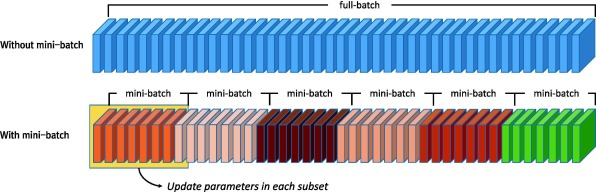

### epoch와 batch

위에서 batch가 나오고 또 다른 batch가 나와서 헷갈렸는데요. 이번에 나온 batch는 'mini batch'라고 생각하시면 됩니다.

첫번째로 id당 600개씩 batch를 묶었습니다. 따라서 3,125개 batch를 학습 모델에 넣습니다.

두번째로, 3,125개의 데이터를 128개 mini-batch로 나누었습니다. 24~25번 업데이트.

한 epoch당 전체 3,125개 batch를 학습하는데, 그 안에서 128개 mini batch로 또 나눠 업데이트합니다.

따라서 한번 학습할 때마다 mini batch만큼 업데이트하고, 그렇게 한번 학습한 걸 바탕으로 다음 학습에 반영해서 업데이트 합니다.

# 예측(테스트)

In [23]:
test_X=tf.reshape(np.array(test_feature.iloc[:,2:]),[-1, 600, 6])

test_feature도 train_feature와 같이 array 형태로 바꿔줍니다

In [24]:
pred = model.predict(test_X)

In [28]:
pred[1] # 확률

array([3.33783450e-03, 6.48323894e-02, 3.17508202e-05, 3.46876157e-04,
       6.44499320e-04, 1.63810662e-04, 1.91434019e-03, 4.69665276e-03,
       2.76879175e-04, 1.58239119e-02, 2.02124822e-03, 1.80083269e-03,
       4.88212800e-06, 1.01729389e-03, 8.71811295e-04, 2.32284638e-05,
       2.31373333e-03, 4.00495599e-04, 2.69551808e-03, 1.10891108e-06,
       1.00305624e-05, 3.27982561e-04, 6.36337965e-04, 1.75012054e-03,
       4.04045172e-03, 2.65591661e-04, 8.41727555e-01, 1.27811707e-03,
       6.75873935e-08, 8.32873229e-06, 2.02678237e-03, 3.59267404e-04,
       1.01126236e-04, 8.44134763e-03, 2.53883627e-04, 3.34561955e-05,
       5.77178835e-05, 1.19341596e-03, 1.14151364e-04, 5.04731361e-07,
       7.23053410e-04, 7.47644344e-06, 9.43752384e-05, 5.36081323e-04,
       7.05972547e-04, 5.23995468e-03, 1.40569624e-04, 2.08040059e-04,
       2.73030950e-04, 2.61791563e-03, 8.36105086e-03, 1.80784205e-04,
       2.49118548e-05, 5.98673832e-05, 7.52647815e-04, 1.38352028e-04,
      

참고: 2.72620656e-03 $ = 2.72620656 * 10^-3 = 0.00272620656 $

In [105]:
# 수치 중에서 max만

pred.argmax(axis=1)

array([26, 26, 26, 26, 26, 26, 26, 26,  8, 26, 26, 28, 26, 26, 26, 26, 18,
       26,  8, 26, 26, 26, 26, 26, 26, 26, 60, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 28,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 18, 26, 26, 26, 26, 26, 26,
       26,  2, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26,  8, 26, 28, 26,  8, 26, 26, 26, 36, 26, 26,
       26, 26, 28, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,  8, 26,
       26, 26, 26, 26, 26, 20, 28, 26, 26, 26, 26,  3, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 28, 28, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26, 26

아래는 인덱스를 운동 이름으로 확인하기 위해 진행한 수작업입니다.

In [73]:
# train_label에서 중복 제거, id 칼럼 drop
a

,label,label_desc
0,37,Shoulder Press (dumbbell)
1,26,Non-Exercise
2,3,Biceps Curl (band)
12,39,Side Plank Right side
13,28,Plank
...,...,...
301,9,Dip
435,20,Kettlebell Swing
447,13,Dumbbell Row (knee on bench) (right arm)
455,22,Lawnmower (left arm)


In [74]:
# {label:운동명}으로 딕셔너리 생성

b = {}
for k, v in zip(a.iloc[:, 0], a.iloc[:, 1]):
    b[k] = v

In [106]:
# key값으로 운동명 찾아 리스트 생성

answer = []
for i in pred.argmax(axis=1):
    answer.append(b[i])
answer

['Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Device on Table',
 'Non-Exercise',
 'Non-Exercise',
 'Plank',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Jump Rope',
 'Non-Exercise',
 'Device on Table',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Wall Squat',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Plank',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exercise',
 'Non-Exer